In [13]:
# Plan of Action
# plot all tackle distance data to determine methodology for picking playmaking threshold
    # Find distance between tackler and ball when ball carrier gets ball
# come up with cone of influence equation 
# distance delta pipeline


 #cone is where the defender could make the tackle

# ONLY LOOK AT RUN PLAYS FOR NOW
# Chase down efficiency
    # How well does each defender's cone move towards the ball carrier
        # Have a minimum distance to be able to be considered for the play
            # distribution of tackler's distance moved from play, get the upper quartile as the min distance
        # How do we judge how effectively they move there?
            # is it just distance delta?
                # consider derivative of distance over time as metric in concern
            # is it moving to final tackle location
            # is it cone overlap delta?

# Once cone overlap reaches threshold, chaser converts to prospective tackler
    # Use this to consider conversion rates for chasers

# Tackle probability - for all prospective tacklers
    # after ball carrier is in cone, how well does tackler make tackle
        # cone overlap integral
        # how fast does cone overlap area increase
        # 
##

#bivariate distribution - x is normally distributed, y is skewed distributed
# these distributions are centered on the player's location and have stdev of some formula of velocity and weight
#the combined distribution comes from multipying the x and y distribution because we're assuming independence


In [64]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import math
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
# Game info - id, week, date, time, teams, scores
games = pd.read_csv("games.csv")


In [3]:
plays = pd.read_csv("plays.csv")
plays['gameClockSeconds'] = pd.to_datetime(plays['gameClock'], format='%M:%S').dt.minute * 60 + pd.to_datetime(plays['gameClock'], format='%M:%S').dt.second
plays.sort_values(by=["gameId", "quarter", "gameClockSeconds"], ascending=[True, True, False], inplace=True)
# plays.head()
# print(plays[["gameId", "gameClockSeconds"]])
plays['penaltyYards'].fillna(0, inplace=True)
plays['passLength'].fillna(0, inplace=True)

plays['passResult'] = plays['passResult'].replace('R', 'Q')
plays['passResult'] = plays['passResult'].fillna('R')
print(plays['passResult'])
print(plays.columns)

4888     C
2818     Q
7699     R
6264     C
3626     R
        ..
11767    R
11619    R
1888     R
9337     R
1576     R
Name: passResult, Length: 12482, dtype: object
Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [4]:
plays.drop("gameClock", axis=1, inplace=True)
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
4888,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,900
2818,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN,869
7699,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN,834
6264,2022090800,122,47857,Devin Singletary,(13:15) (Shotgun) J.Allen pass short right to ...,1,2,3,BUF,LA,...,0.615031,-0.019032,0.019032,2.689053,0.399209,NaN,NaN,NaN,NaN,795
3626,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN,753


In [5]:
players = pd.read_csv("players.csv")
players['birthDate'] = pd.to_datetime(players['birthDate'])
reference_date = dt(2022, 9, 8)
players['age'] = players['birthDate'].apply(lambda x: reference_date.year - x.year - ((reference_date.month, reference_date.day) < (x.month, x.day)))
players.drop('birthDate', axis = 1, inplace=True)
players.drop('collegeName', axis = 1, inplace=True)
players.head()

,nflId,height,weight,position,displayName,age
0,25511,4-Jun,225,QB,Tom Brady,45.0
1,29550,4-Jun,328,T,Jason Peters,40.0
2,29851,2-Jun,225,QB,Aaron Rodgers,38.0
3,30842,6-Jun,267,TE,Marcedes Lewis,38.0
4,33084,4-Jun,217,QB,Matt Ryan,37.0


In [6]:
tackles = pd.read_csv("tackles.csv")
tackles.head()
missed_tackles = tackles[tackles['pff_missedTackle'] == 1]
tackles = tackles[tackles['pff_missedTackle'] != 1]

In [7]:
w1 = pd.read_csv("tracking_week_1.csv")
w2 = pd.read_csv("tracking_week_2.csv")
w3 = pd.read_csv("tracking_week_3.csv")
w4 = pd.read_csv("tracking_week_4.csv")
w5 = pd.read_csv("tracking_week_5.csv")
w6 = pd.read_csv("tracking_week_6.csv")
w7 = pd.read_csv("tracking_week_7.csv")
w8 = pd.read_csv("tracking_week_8.csv")
w9 = pd.read_csv("tracking_week_9.csv")

In [8]:
all_weeks = pd.concat([w1, w2, w3, w4, w5, w6, w7, w8, w9])
all_weeks.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


In [9]:
# want ballcarrier data for each play
# player name, player id, gameid, playid, x, y, s, etc. for all the moments that they have recieved the ball from the qb
temp = w1
temp.dropna(subset=['event'], inplace=True)
# Assuming your DataFrame is named df and contains the 'event' column

# Filtering to get rows where 'event' column doesn't contain 'pass', 'tackle', or 'contact'
filtered_events = temp[~temp['event'].str.contains('pass|tackle|contact', na=False, case=False)]['event']

# Displaying the unique filtered events
unique_filtered_events = filtered_events.unique()
print(unique_filtered_events)

#temp = temp[~temp['event'].str.contains('tackle', na=False)]['event']
# temp = temp[~temp['event'].str.contains('contact', na=False)]['event']
# type(w1.iloc[1,16])
w1[w1['event'] == 'run']
plays[plays["playId"] == 101][plays["gameId"] == 2022090800]

['run' 'ball_snap' 'handoff' 'touchdown' 'out_of_bounds' 'man_in_motion'
 'fumble' 'play_action' 'lateral' 'line_set' 'qb_slide' 'shift' 'qb_sack'
 'autoevent_ballsnap' 'snap_direct' 'fumble_defense_recovered'
 'fumble_offense_recovered']


C:\Users\theep\AppData\Local\Temp\ipykernel_69500\470345304.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plays[plays["playId"] == 101][plays["gameId"] == 2022090800]


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
7699,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,834


In [10]:
#plays.head()
print(plays.columns)
plays.drop(columns=['quarter', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'yardlineSide',
                    'passLength', 'penaltyYards', 'prePenaltyPlayResult', 'playNullifiedByPenalty',
                    'passProbability', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
                    'visitorTeamWinProbilityAdded'], inplace=True)

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'passLength', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [13]:
print(all_weeks['event'].unique())
print(all_weeks['event'].value_counts())
# print(all_weeks['event'].value_counts().get('handoff'))

[nan 'pass_arrived' 'pass_outcome_caught' 'tackle' 'run' 'first_contact'
 'ball_snap' 'handoff' 'touchdown' 'out_of_bounds' 'man_in_motion'
 'fumble' 'play_action' 'pass_forward' 'lateral' 'autoevent_passforward'
 'autoevent_passinterrupted' 'line_set' 'qb_slide' 'shift'
 'run_pass_option' 'qb_sack' 'pass_shovel' 'autoevent_ballsnap'
 'snap_direct' 'fumble_defense_recovered' 'fumble_offense_recovered'
 'penalty_flag' 'safety' 'pass_outcome_touchdown' 'penalty_accepted']
event
first_contact                242259
tackle                       230921
ball_snap                    145405
handoff                      135378
pass_outcome_caught          130087
pass_arrived                 113825
out_of_bounds                 41629
run                           21804
man_in_motion                  9683
touchdown                      9523
play_action                    6463
shift                          3358
qb_slide                       3158
fumble                         2415
pass_forward   

In [15]:
#calculate distance threshold
# array storing the distance from the tackler to the point of reception/handoff at the moment of play start
all_start_dists = []
# Stores tuple of (playId, gameId, start frame #, defensive team)
play_nums = []
error_counter = 0
for index, play in tackles.iterrows(): 
    current_game_id = play['gameId']
    current_play_id = play['playId']
    #filter to only run plays, filter current_play down to only tackler and ball_carrier to calculate the threshold
    if (plays[(plays['gameId'] == current_game_id) & (plays['playId'] == current_play_id)]['passResult'].values[0] != 'R'):
        continue
    tackler_id = play['nflId']
    ball_carrier_id = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['ballCarrierId'].iloc[0]
    current_play = all_weeks[(all_weeks['gameId'] == current_game_id) & (all_weeks['playId'] == current_play_id)]
    current_play = current_play[(current_play["nflId"] == tackler_id) | (current_play["nflId"] == ball_carrier_id) | (current_play["displayName"] == 'football')]
    defensive_team = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['defensiveTeam'].iloc[0]
    #get moment of handoff = startFrame
    curr_frame = pd.DataFrame()

    if (current_play['event'] == 'handoff').any():
        curr_frame = current_play[current_play['event'] == 'handoff']
        start_frame = curr_frame['frameId'].iloc[0]
        min_dist_positions[0] = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
        min_dist_positions[1] = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
    
    else:
        min_dist = 100
        # saves the following at moment of reception/handoff: 
        #   [ball_carrier_x, ball_carrier_y]
        min_dist_positions = [-1, -1]
        start_frame = -1
        # print("play: ", index)
        for i in range(1,max(current_play['frameId'])):
            curr_frame = current_play[current_play['frameId'] == i]
            ball_carrier_x = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
            ball_carrier_y = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
            football_x = curr_frame[curr_frame['displayName'] == 'football']['x'].iloc[0]
            football_y = curr_frame[curr_frame['displayName'] == 'football']['y'].iloc[0]
            
            dist = math.dist([ball_carrier_x, ball_carrier_y], [football_x, football_y])
            if dist < min_dist:
                min_dist = dist
                min_dist_positions[0] = ball_carrier_x
                min_dist_positions[1] = ball_carrier_y
                start_frame = i
                if dist < .4:
                    break
        #just ensure start_frame isn't too late

    
    #extract the startframe
    curr_frame = current_play[current_play['frameId'] == start_frame]
    curr_frame = curr_frame[curr_frame["nflId"] == tackler_id]
    tackler_x = curr_frame.iloc[0, 9]
    tackler_y = curr_frame.iloc[0, 10]
    tackler_distance = math.dist([min_dist_positions[0], min_dist_positions[1]], [tackler_x, tackler_y])
    b = (current_game_id, current_play_id, start_frame, defensive_team)
    all_start_dists.append(tackler_distance)
    if b not in play_nums:
        play_nums.append(b)

In [18]:
# After running previous cell, all_start_dists has all the distances from ball carrier to tackler at playstart
# for outlier using 1.5IQR + Q3 

all_start_dists = np.array(all_start_dists)

quartile_3 = np.percentile(all_start_dists, 75)
quartile_1 = np.percentile(all_start_dists, 25)

potential_tackler_threshold = quartile_3 + 1.5*(quartile_3  - quartile_1)
print(potential_tackler_threshold)
plt.hist(all_start_dists, bins = 60)

16.3308356384916


In [19]:
df = all_weeks.merge(plays, on=['gameId', 'playId'], how='inner')


In [20]:
valid = []

for game_id, play_id, start_frame, def_club in play_nums:
    # Selecting the plays and the right frames
    play_df = df[(df['gameId'] == game_id) & (df['playId'] == play_id) & (df['frameId'] >= start_frame)]

    # Filtering offensive players and football
    off_club = play_df[play_df['club'] != def_club]
    #getting start rows for defensive players
    start_frame_rows = play_df[(play_df['club'] == def_club) & (play_df['frameId'] == start_frame)]

    ball_carrier_name = start_frame_rows['ballCarrierDisplayName'].iloc[0]
    valid_player_names = [player for player in start_frame_rows['displayName'] if 
                          (math.dist([start_frame_rows[start_frame_rows['displayName'] == player]['x'].iloc[0], 
                                      start_frame_rows[start_frame_rows['displayName'] == player]['y'].iloc[0]],
                                     [off_club[off_club['displayName'] == ball_carrier_name]['x'].iloc[0], 
                                      off_club[off_club['displayName'] == ball_carrier_name]['y'].iloc[0]])
                          < potential_tackler_threshold)]
    def_club_filtered = play_df[play_df['displayName'].isin(valid_player_names)]
    valid.extend([off_club, def_club_filtered])

    # print(len(play_df), len(off_club), len(def_club_filtered), len(off_club) + len(def_club_filtered), len(valid_player_names))
    if (len(off_club) + len(def_club_filtered) > len(play_df)):
        print("gotem")
        print(game_id, play_id, start_frame, def_club)
        break

# Concatenate the results outside the loop
#valid_players_df = pd.concat(valid)


In [21]:
# valid_players is a subset of all_weeks and plays
valid_players = pd.concat(valid)

In [22]:
defensive_positions = ('DE', 'SS', 'FS', 'OLB', 'DT', 'CB', 'MLB')

defensive_players = []
for pos in defensive_positions:
    defensive_players.append(list(players[players['position'] == pos]
                                  .drop(columns=['height', 'weight', 'position', 'displayName', 'age'])['nflId']))


In [29]:
game_ids_to_keep = [item[0] for item in play_nums]
play_ids_to_keep = [item[1] for item in play_nums]

tackles_for_stdev = tackles[(tackles["gameId"].isin(game_ids_to_keep)) & (tackles['playId'].isin(play_ids_to_keep))]

In [61]:
defensive_distances_at_tackle = {'DE':([], []), 'SS':([], []), 'FS':([], []), 'OLB':([], []), 'DT':([], []), 'CB':([], []), 'MLB':([], [])}
runcoutn = 0
for index, row in tackles_for_stdev.iterrows():
    game_id = row['gameId']
    play_id = row['playId']
    ball_carrier_id = plays[(plays['playId'] == play_id) & (plays['gameId'] == game_id)]['ballCarrierId'].iloc[0]
    tackler_id = row['nflId']
    curr_frame = all_weeks[(all_weeks['gameId'] == game_id) & (all_weeks['playId'] == play_id)]
    curr_frame = curr_frame[(curr_frame['event'] == 'tackle') | (curr_frame['event'] == 'out_of_bounds') | 
                            (curr_frame['event'] == 'fumble') | (curr_frame['event'] == 'qb_slide') | (curr_frame['event'] == 'safety')]
    x_dist = abs(curr_frame[curr_frame['nflId'] == tackler_id]['x'].iloc[0] - curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0])
    y_dist = abs(curr_frame[curr_frame['nflId'] == tackler_id]['y'].iloc[0] - curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0])
    pos = players[players['nflId'] == tackler_id]['position'].iloc[0]
    defensive_distances_at_tackle[pos][0].append(x_dist)
    defensive_distances_at_tackle[pos][1].append(y_dist)
    

single positional indexer is out-of-bounds
2022110600 3654
single positional indexer is out-of-bounds
2022103009 2259
single positional indexer is out-of-bounds
2022101610 499
single positional indexer is out-of-bounds
2022110600 3654


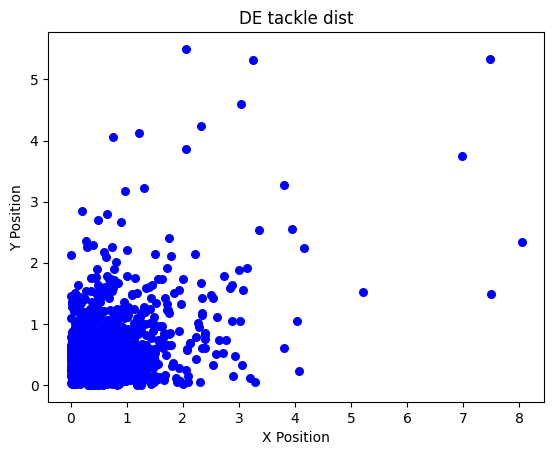

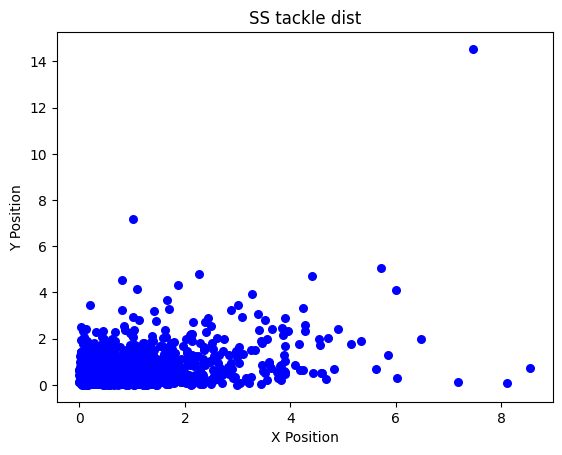

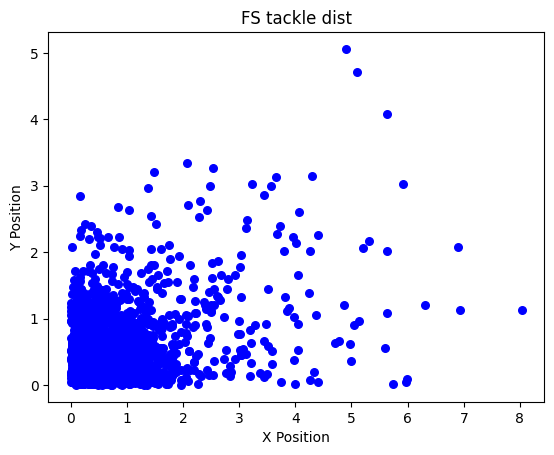

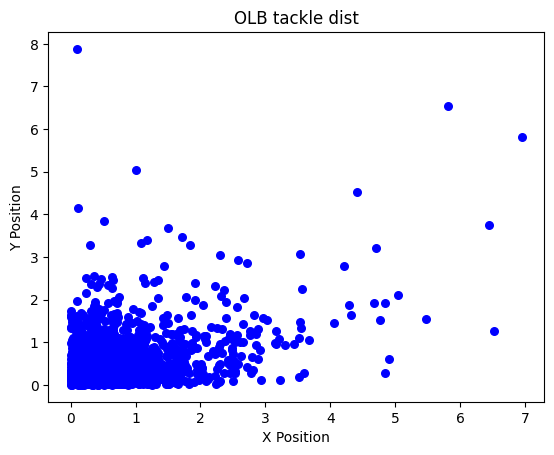

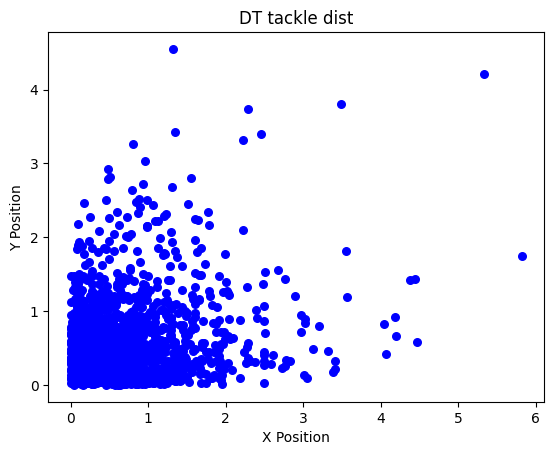

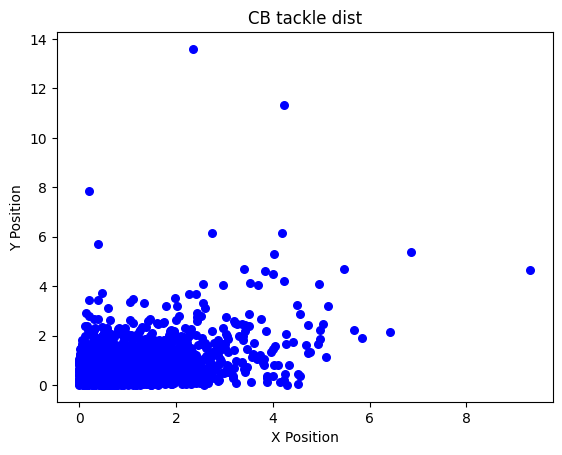

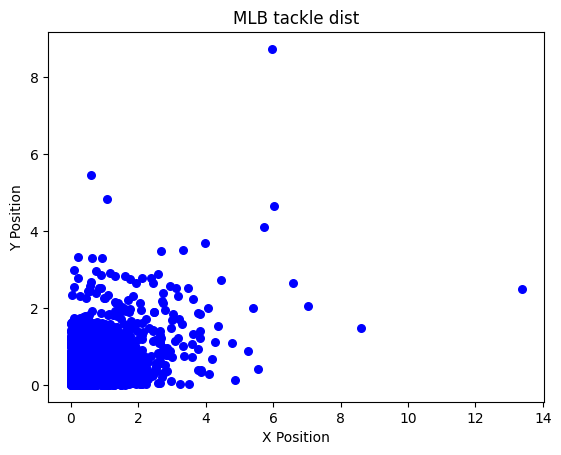

In [69]:
for pos, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    plt.scatter(x_dists, y_dists, color='blue', marker='o', s=30)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'{pos} tackle dist')
    plt.show()
# pprint(defensive_distances_at_tackle)

In [68]:
defensive_stats = {'DE':(0,0), 'SS':(0,0), 'FS':(0,0), 'OLB':(0,0), 'DT':(0,0), 'CB':(0,0), 'MLB':(0,0)}

# Calculate mean and std for each key
for key, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    mean_x = np.mean(x_dists)
    std_x = np.std(x_dists)
    mean_y = np.mean(y_dists)
    std_y = np.std(y_dists)
    
    defensive_stats[key] = ((mean_x, std_x), (mean_y, std_y))

# Display the result
pprint(defensive_stats)



{'CB': ((0.871428046989721, 0.8858695225043356),
        (0.6747907488986784, 0.7388558197917336)),
 'DE': ((0.727938808373591, 0.7396264471202605),
        (0.5861272141706924, 0.5938808144903953)),
 'DT': ((0.6727248249865372, 0.6280289500346459),
        (0.544232633279483, 0.5233315316617766)),
 'FS': ((0.9152190721649487, 0.9850438675914651),
        (0.6063530927835051, 0.5695598536342585)),
 'MLB': ((0.7134564917127072, 0.750693165067729),
         (0.5382734806629835, 0.5364128371302845)),
 'OLB': ((0.7226932668329177, 0.733723009413766),
         (0.559715710723192, 0.5789216641692078)),
 'SS': ((0.9498202396804263, 1.0055923691830586),
        (0.6672037283621838, 0.7508742599355561))}


In [ ]:
# STDEV strat: group by position, calculate variance for each player based on their dist from tackle in x/y
#     give any player that doesnt have 

# To get distributions, use below Code
# keep in mind that it may have to be subtractive if offense has the def player blocked
# if dist is subtracted from, normalize again to maintain integral = 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm

def rotate_point(x, y, theta):
    """
    Apply a rotation to a point (x, y) by an angle theta (in radians).
    """
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                [np.sin(theta), np.cos(theta)]])
    return np.dot(rotation_matrix, np.array([x, y]))

# Number of samples and angle of rotation
n = 1000
theta = np.radians(30)  # Rotate by 45 degrees, for example

# Generate a normal distribution for x
y = np.random.normal(0, 1, n)

# Generate a skewed normal distribution for y
a = 10  # skewness parameter
x = skewnorm.rvs(a, size=n)

# Points for calculating PDFs
x_points = np.linspace(-5, 5, 70)
y_points = np.linspace(-1, 3, 70)
pdf_x_points = norm.pdf(x_points, loc=0, scale=0.5)
pdf_y_points = skewnorm.pdf(y_points, a)

# Creating a meshgrid for the joint distribution
X, Y = np.meshgrid(x_points, y_points)
print(type(pdf_x_points))
# Rotate each point in the meshgrid
X_rot, Y_rot = np.empty_like(X), np.empty_like(Y)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        X_rot[i, j], Y_rot[i, j] = rotate_point(X[i, j], Y[i, j], theta)

# Compute the joint PDF on the rotated grid
joint_pdf_rotated = np.outer(pdf_y_points, pdf_x_points)

# Plotting the rotated joint PDF
plt.figure(figsize=(10, 6))
plt.contourf(X_rot, Y_rot, joint_pdf_rotated, cmap="viridis")
plt.colorbar(label='Probability Density')
plt.title("Rotated Joint PDF of X (Normal) and Y (Skewed Normal)")
plt.xlabel("X'")
plt.ylabel("Y'")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def create_football_field():
    """
    Creates a football field for plotting.
    """
    field = plt.figure(figsize=(12, 6.33))
    ax = field.add_subplot(1, 1, 1)

    # Create the green field
    plt.plot([0, 120], [0, 0], color="green")
    ax.set_facecolor('green')

    # Add major lines
    for x in range(10, 110, 10):
        line = patches.Rectangle((x, 0), 1, 53.3, linewidth=1, edgecolor='white', facecolor='white')
        ax.add_patch(line)

    # Add endzones
    endzone1 = patches.Rectangle((0, 0), 10, 53.3, linewidth=1, edgecolor='white', facecolor='blue')
    endzone2 = patches.Rectangle((110, 0), 10, 53.3, linewidth=1, edgecolor='white', facecolor='blue')
    ax.add_patch(endzone1)
    ax.add_patch(endzone2)

    # Set limits and labels
    plt.xlim(0, 120)
    plt.ylim(0, 53.3)
    plt.xlabel('Yards (Length of Field)')
    plt.ylabel('Yards (Width of Field)')
    plt.title('NFL Football Field')
    
    return ax
ax = create_football_field()
for game_id, play_id, start_frame, def_club in play_nums:
    curr_play_def = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id) & (valid_players['frameId'] == start_frame)
                              & (valid_players['club'] == def_club)]
    curr_play_off = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id) & (valid_players['frameId'] == start_frame)
                              & (valid_players['club'] != def_club)]
    print(len(curr_play_off))
    # for playerId in curr_play_def['nflId'].unique():
    #     player_data = curr_play_def[curr_play_def['nflId'] == playerId]
    #     player_x, player_y, player_dir = player_data['x'].iloc[0], player_data['y'].iloc[0], player_data['dir'].iloc[0]
    #     theta = np.radians(player_dir)  # Convert direction to radians

    #     # Generate a normal distribution centered at player's position
    #     x_points = np.linspace(player_x - 3, player_x + 3, 70)
    #     y_points = np.linspace(player_y - 3, player_y + 3, 70)
    #     pdf_x_points = norm.pdf(x_points, loc=player_x, scale=1)
    #     pdf_y_points = norm.pdf(y_points, loc=player_y, scale=1)
        
    #     # Creating a meshgrid for the joint distribution
    #     X, Y = np.meshgrid(x_points, y_points)

    #     # Rotate each point in the meshgrid
    #     X_rot, Y_rot = np.empty_like(X), np.empty_like(Y)
    #     for i in range(X.shape[0]):
    #         for j in range(X.shape[1]):
    #             X_rot[i, j], Y_rot[i, j] = rotate_point(X[i, j] - player_x, Y[i, j] - player_y, theta)

    #     # Shift back to player's position
    #     X_rot += player_x
    #     Y_rot += player_y
        
    #     # Compute the joint PDF on the rotated grid
    #     joint_pdf_rotated = np.outer(pdf_y_points, pdf_x_points)

    #     # Plotting the rotated joint PDF
    #     for i in range(len(joint_pdf_rotated)):
    #         for j in range(len(joint_pdf_rotated[i])):
    #             if joint_pdf_rotated[i][j] < .05:
    #                 joint_pdf_rotated[i][j] = np.NaN

    #     ax.contourf(X_rot, Y_rot, joint_pdf_rotated, cmap="viridis", alpha=1)
    print(curr_play_off)
    for playerId in curr_play_off['nflId'].unique():
        player_data = curr_play_off[curr_play_off['nflId'] == playerId]
        print(playerId)
        player_x, player_y, player_dir = player_data['x'].iloc[0], player_data['y'].iloc[0], player_data['dir'].iloc[0]
        theta = np.radians(player_dir)  # Convert direction to radians

        # Generate a normal distribution centered at player's position
        x_points = np.linspace(player_x - 3, player_x + 3, 70)
        y_points = np.linspace(player_y - 3, player_y + 3, 70)
        pdf_x_points = norm.pdf(x_points, loc=player_x, scale=1)
        pdf_y_points = norm.pdf(y_points, loc=player_y, scale=1)
        
        # Creating a meshgrid for the joint distribution
        X, Y = np.meshgrid(x_points, y_points)

        # Rotate each point in the meshgrid
        X_rot, Y_rot = np.empty_like(X), np.empty_like(Y)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                X_rot[i, j], Y_rot[i, j] = rotate_point(X[i, j] - player_x, Y[i, j] - player_y, theta)

        # Shift back to player's position
        X_rot += player_x
        Y_rot += player_y
        
        # Compute the joint PDF on the rotated grid
        joint_pdf_rotated = np.outer(pdf_y_points, pdf_x_points)

        # Plotting the rotated joint PDF
        for i in range(len(joint_pdf_rotated)):
            for j in range(len(joint_pdf_rotated[i])):
                if joint_pdf_rotated[i][j] < .05:
                    joint_pdf_rotated[i][j] = np.NaN

        ax.contourf(X_rot, Y_rot, joint_pdf_rotated, cmap="BuPu", alpha=1)
    break
    

In [ ]:
#only selecting the plays we want, and the right frames from those plays
correct_frames = []
for gameId, playId, startFrame, def_club in play_nums:
    temp = df[(df['gameId'] == gameId) & (df['playId'] == playId)]
    temp = temp[temp['frameId'] >= startFrame]
    correct_frames.append(temp)

correct_frames_df = pd.concat(correct_frames)